In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget

import matplotlib.pyplot as plt # For general plotting
from matplotlib.ticker import MaxNLocator
from math import ceil, floor
import numpy as np
from skimage.io import imread
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold, GridSearchCV



np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(4)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title



Text(0.5, 1.0, 'lady')

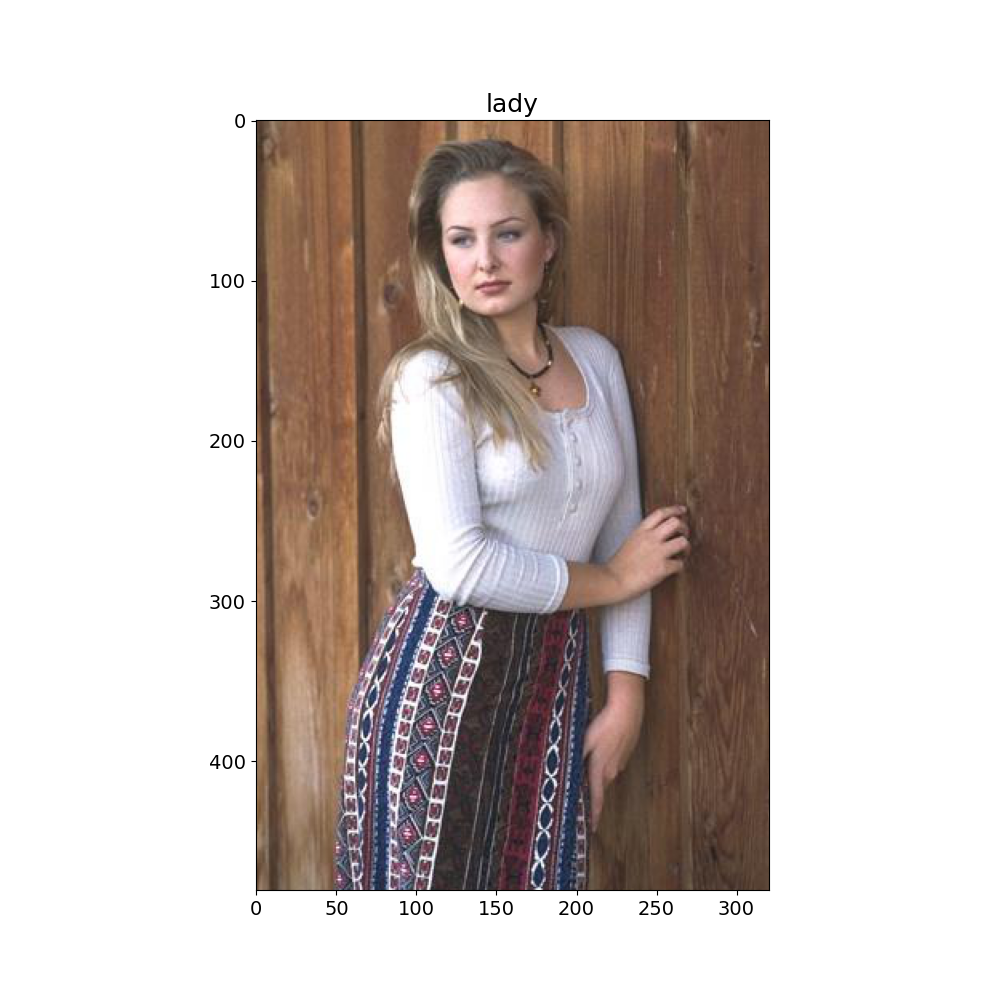

In [17]:
# boat_color = imread('https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300/html/images/plain/normal/color/118020.jpg')

lady_color = imread('graphs/lady.jpeg')

fig = plt.figure(figsize=(10, 10))
plt.imshow(lady_color)
plt.title("lady")


In [8]:
def generate_feature_vector(image):
    # Load image, get its dimensions
    image_np = np.array(image)
    # Return an array of the row and column indices of the image (height and width)
    img_indices = np.indices((image_np.shape[0], image_np.shape[1]))

    # Set up data array to store features: row ind, col ind, [num_channels]
    # num_channels = 1 for grayscale and 3 for RGB
    if image_np.ndim == 2:  # Grayscale image
        # Create the features matrix of row and col indices, plus pixel values
        features = np.array([img_indices[0].flatten(), img_indices[1].flatten(), image_np.flatten()])
        # Find ranges of features as max - min
        min_f = np.min(features, axis=1)
        max_f = np.max(features, axis=1)
        ranges = max_f - min_f
        # Each feature normalized to the unit interval [0,1] using max-min normalization: (x - min) / (max - min)
        # New axis to allow numpy broadcasting
        # np.diag(1/ranges) to perform the division operation in matrix form
        normalized_data = np.diag(1 / ranges).dot(features - min_f[:, np.newaxis])
    elif image_np.ndim == 3: # Color image with RGB values
        # Create the features matrix of row and col indices, plus pixel values
        features = np.array([img_indices[0].flatten(), img_indices[1].flatten(),
                             image_np[..., 0].flatten(), image_np[..., 1].flatten(), image_np[..., 2].flatten()])
        min_f = np.min(features, axis=1)
        max_f = np.max(features, axis=1)
        ranges = max_f - min_f
        # Each feature normalized to the unit interval [0,1] using max-min normalization: (x - min) / (max - min)
        # New axis np.newaxis to allow numpy broadcasting
        # np.diag(1/ranges) to perform the division operation in matrix form
        normalized_data = np.diag(1 / ranges).dot(features - min_f[:, np.newaxis])
    else:
        print("Incorrect image dimensions for feature vector")

    # Returns feature vector of normalized pixels as shape (height*width, 3 or 5)
    return image_np, normalized_data.T

Text(0.5, 1.0, 'GMM Image Segmentation Result When $K = 5$')

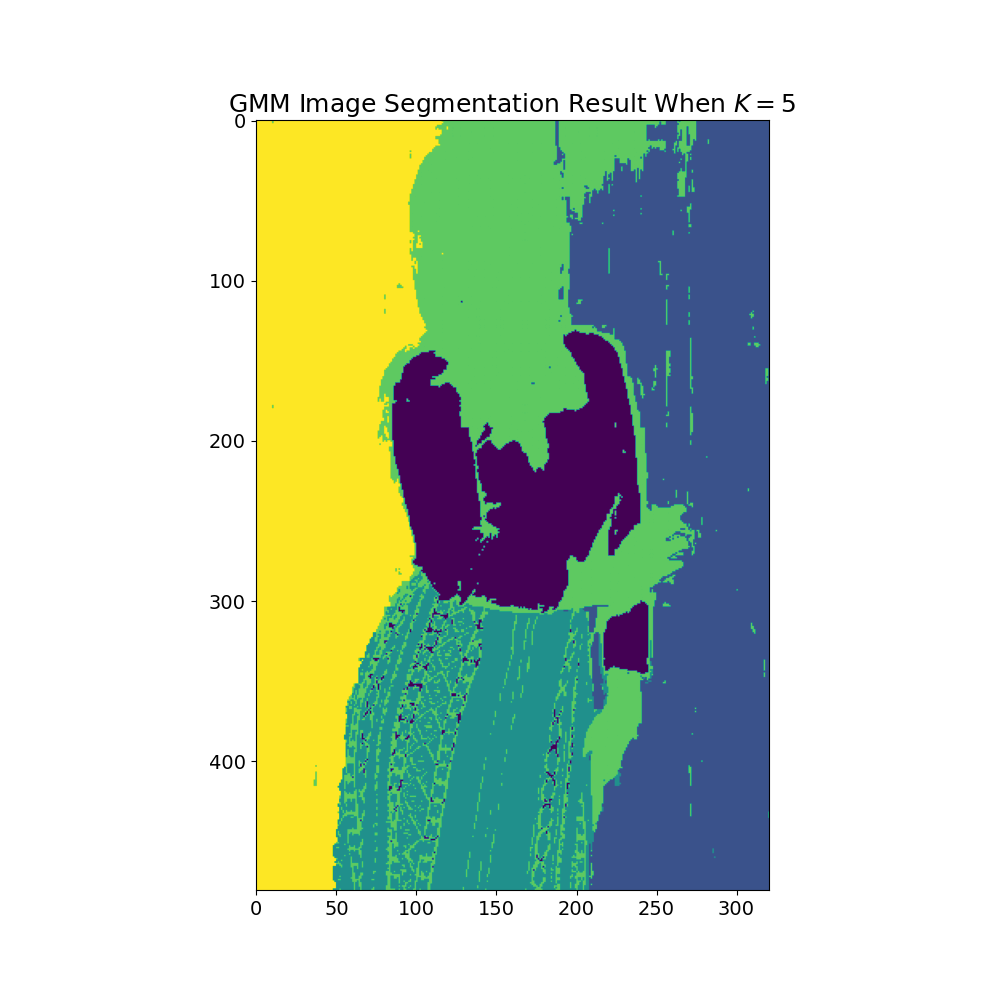

In [22]:
## Generate feature vector on the image
img_np, feature_vector = generate_feature_vector(lady_color)

# Perform EM to estimate the parameters of the GMM using fit() and default parameters
gmm = GaussianMixture(n_components=5, max_iter=400, tol=1e-3)

# Hard clustering using argmax to compute most probable component labels
gmm_predictions = gmm.fit_predict(feature_vector)

# Assigned segment labels reshaped into an image to color-code pixels
labels_img = gmm_predictions.reshape(img_np.shape[0], img_np.shape[1])
fig = plt.figure(figsize=(10, 10))
plt.imshow(labels_img)
plt.title(r"GMM Image Segmentation Result When $K = 5$")

In [18]:
def k_fold_gmm_components(K, n_components_list, data):
    # STEP 1: Partition the dataset into K approximately-equal-sized partitions
    kf = KFold(n_splits=K, shuffle=True)

    # Allocate space for CV
    log_lld_valid_mk = np.zeros((len(n_components_list), K))

    # STEP 2: Iterate over all model options based on number of components
    # Track model index
    m = 0
    for comp in n_components_list:
        # K-fold cross validation
        k = 0
        for train_indices, valid_indices in kf.split(data):
            gmm = GaussianMixture(n_components=comp, max_iter=400, tol=1e-3).fit(feature_vector)

            # Per-sample average log-likelihood
            log_lld_valid_mk[m, k] = gmm.score(feature_vector)
            k += 1
        m += 1

    # STEP 3: Compute the average validation set log-likelihood (across K folds)
    log_lld_valid_m = np.mean(log_lld_valid_mk, axis=1)

    # Extracting top 3 K-components with largest log-likelihood values, to later illustrate
    best_three_ind = np.argpartition(log_lld_valid_m, -5)[-5:]
    # Need to sort them
    best_three = best_three_ind[np.argsort((-log_lld_valid_m)[best_three_ind])]
    # Optimal K* component is the one that maximizes average validation-log-likelihood
    print("Best No. Cluster Components: %d" % n_components_list[best_three[0]])
    print("Log-likelihood Score: %.3f" % np.max(log_lld_valid_m))

    fig = plt.figure(figsize=(10, 10))
    plt.plot(n_components_list, log_lld_valid_m);
    plt.title("Number of GMM Components vs Cross-Validation Log-Likelihood")
    plt.xlabel(r"$Number of Components$")
    plt.ylabel("Log-likelihood")
    ax = fig.gca();
    ax.xaxis.set_major_locator(MaxNLocator(integer=True));
    plt.show()

    # Return the best three number of components for clustering
    return [n_components_list[i] for i in best_three]

Best No. Cluster Components: 20
Log-likelihood Score: 6.130


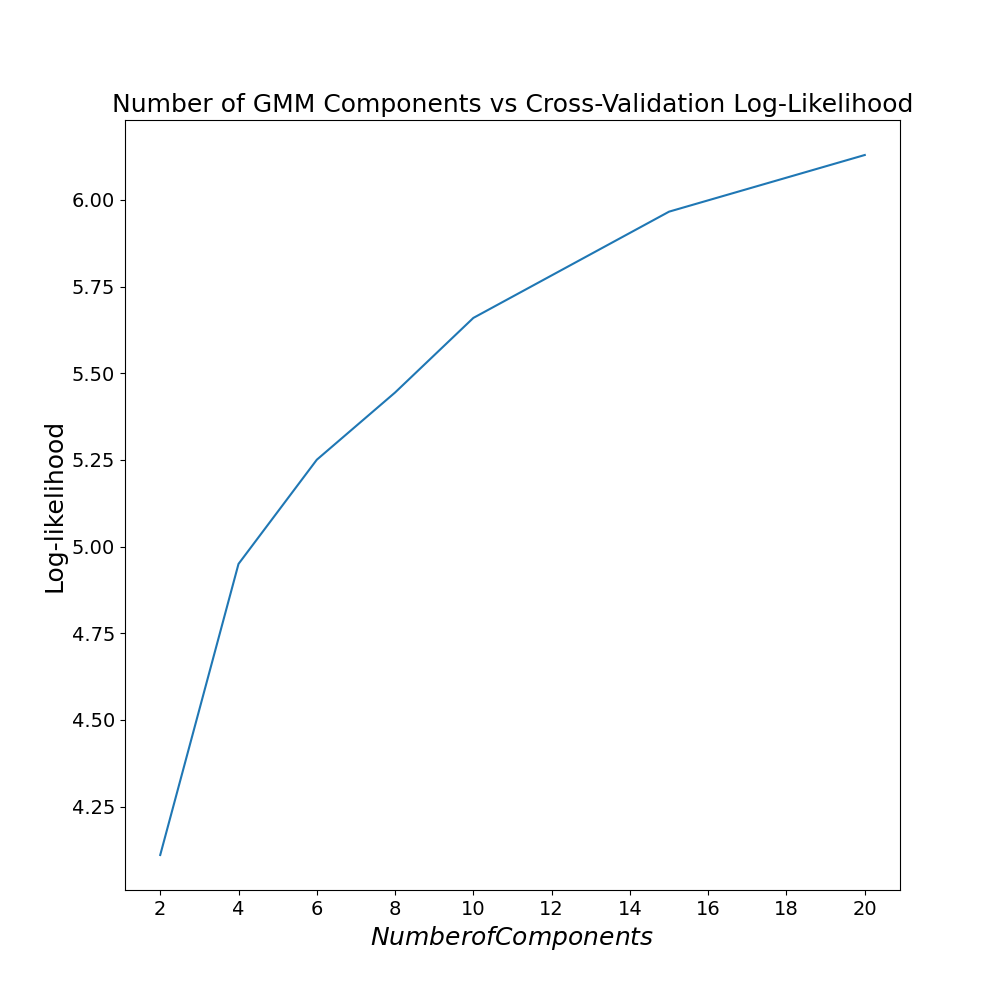

In [19]:
K_folds = 10
n_components_list = [2, 4, 6, 8, 10, 15, 20]

best_three_components = k_fold_gmm_components(K_folds, n_components_list, feature_vector)

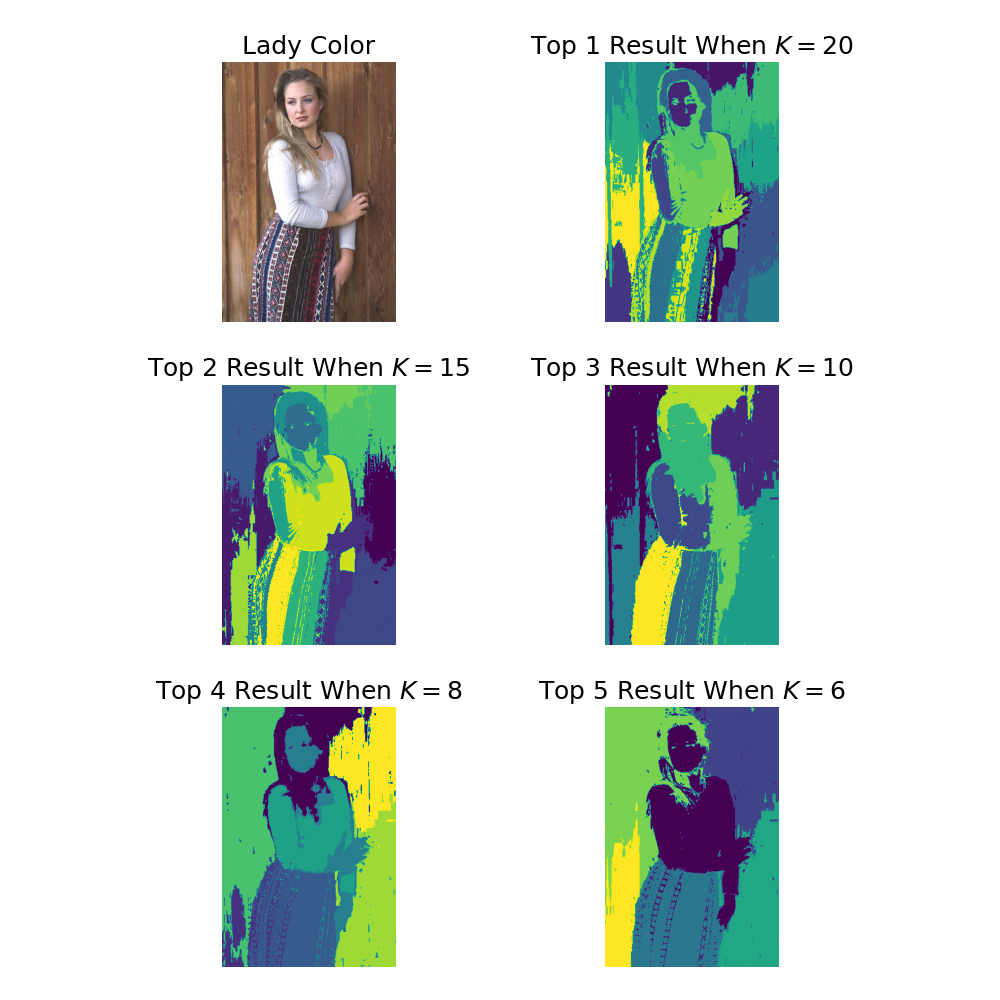

In [21]:
# Create figure to plot all GMM segmentation results for the example image
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
ax[0,0].imshow(lady_color)
ax[0,0].set_title("Lady Color")
ax[0,0].set_axis_off()

# Plot axis index for each clustered image
j = 1
for comp in best_three_components:
    gmm_predictions = GaussianMixture(n_components=comp, max_iter=400, tol=1e-3).fit_predict(feature_vector)
    labels_img = gmm_predictions.reshape(img_np.shape[0], img_np.shape[1])

    ax[floor(j/2),j%2].imshow(labels_img)
    ax[floor(j/2),j%2].set_title(fr"Top {j} Result When $K = {comp}$")
    ax[floor(j/2),j%2].set_axis_off()
    j += 1

plt.tight_layout()
plt.show()